In [1]:
import os
import zipfile

from pathlib import Path

import requests

# 1 - Get Data


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 32.27 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents = True, exist_ok = True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2 Create Datasets and DataLoaders

### 2.1 Creating a transform for torchvision.models (manual creation)

In [5]:
from going_modular.going_modular import data_setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
train_dataLoader, test_dataLoader, classes = data_setup.create_dataloaders(train_dir, test_dir, transform, batch_size = 32)
train_dataLoader, test_dataLoader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7fbb33653890>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models (auto creation)

In [6]:
# get a set of pretrained model weights
weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT -> best available weights <- IMAGENET1K_V1
weight

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
# get the transforms used to create our pretrained weights
auto_transforms = weight.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
train_dataLoader, test_dataLoader, classe = data_setup.create_dataloaders(train_dir = train_dir,
                                                                         test_dir = test_dir,
                                                                         transform = auto_transforms,
                                                                         batch_size = 32)
train_dataLoader, test_dataLoader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7fbb33699f10>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model

In [9]:
# torchvision.models.efficientnet_b0(pretrained = True) # old method of creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 80.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [11]:
model.classifier[1].in_features

1280

### 3.1 Getting a summary of our data with `torchinfo.summary()`


In [12]:
summary(model = model,
        input_size = [32, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.2 Freezing the base model and changing the output layer to suit our needs

In [13]:
# freeze all of the base layers
for params in model.features.parameters():
  params.requires_grad = False

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [15]:
# update the classifier head of our model to suit our problem
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(classes))
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [16]:
summary(model = model,
        input_size = [32, 3, 244, 244],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 244, 244]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 244, 244]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 244, 244]    [32, 32, 122, 122]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 244, 244]    [32, 32, 122, 122]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 122, 122]   [32, 32, 122, 122]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 122, 122]   [32, 32, 122, 122]   --                   --
│    └─Sequential (1)                                        [32, 32, 122, 122]   [32, 

# 4. Train Model

In [17]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [18]:
# import train_model
from going_modular.going_modular import engine
device = "cuda" if torch.cuda.is_available() else "cpu"
from timeit import default_timer as timer
start_time = timer()
results = engine.train(model = model,
             train_dataloader = train_dataLoader,
             test_dataloader = test_dataLoader,
             optimizer = optimizer,
             loss_fn = loss_fn,
             epochs = 5,
             device = device)
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0161 | train_acc: 0.4336 | test_loss: 0.8416 | test_acc: 0.7746
Epoch: 2 | train_loss: 0.9043 | train_acc: 0.5703 | test_loss: 0.8338 | test_acc: 0.6411
Epoch: 3 | train_loss: 0.7314 | train_acc: 0.8438 | test_loss: 0.6998 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.6537 | train_acc: 0.9141 | test_loss: 0.6310 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.6468 | train_acc: 0.7773 | test_loss: 0.6085 | test_acc: 0.8153
[INFO] Total training time: 165.758 seconds


[INFO] Couldn't find helper_functions.py, downloading...


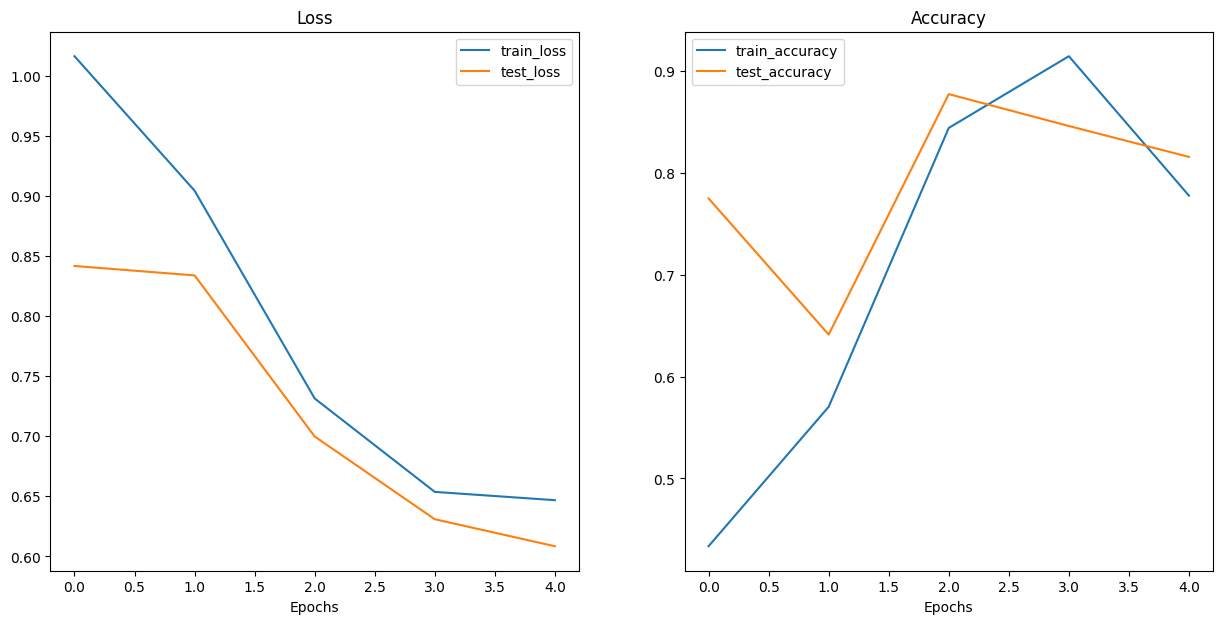

In [19]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

plot_loss_curves(results)

# 5. Make predictions on images from the test set

In [20]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model : torch.nn.Module,
                        image_path : str,
                        class_names : List[str],
                        image_size : Tuple[int, int] = (224, 224),
                        transform : torchvision.transforms = None,
                        device : torch.device = device):

  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize((image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim = 0)
    target_image_pred_logits = model(transformed_image)
  target_image_pred_probs = torch.softmax(target_image_pred_logits, dim = 1)
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim = 1)

  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_labels]}, Prob: {target_image_pred_probs.max():.3f}")
  plt.axis("off")

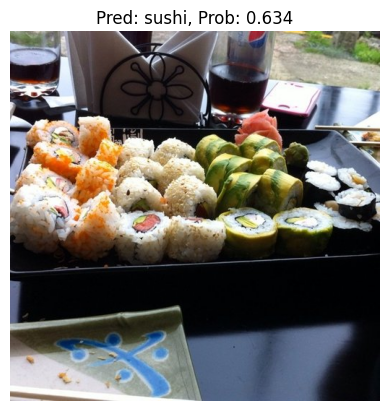

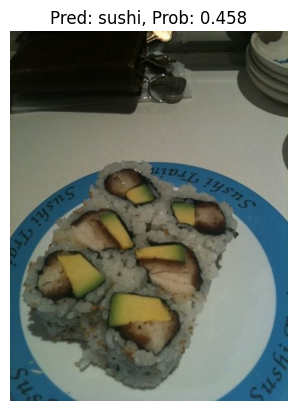

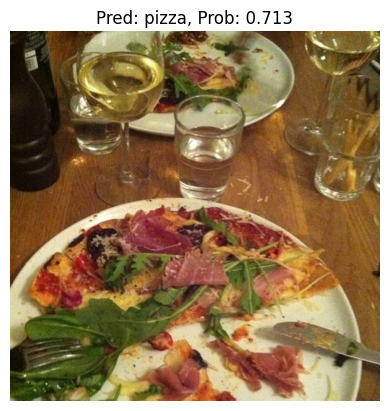

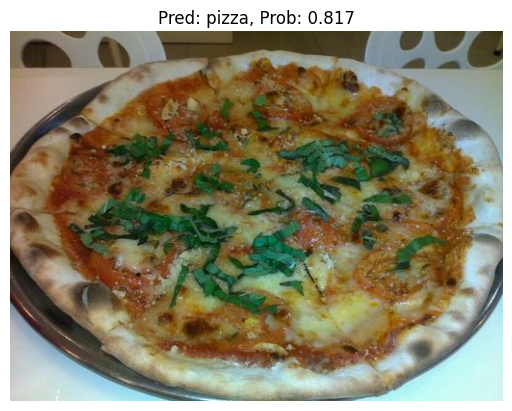

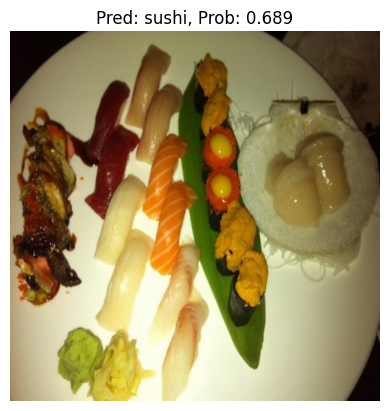

In [21]:
import random
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_samples = random.sample(population = test_image_path_list, k = 5)
for image_path in test_image_path_samples:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = classes,
                      image_size = (224, 224))

# 6.  Making predictions on a custom image

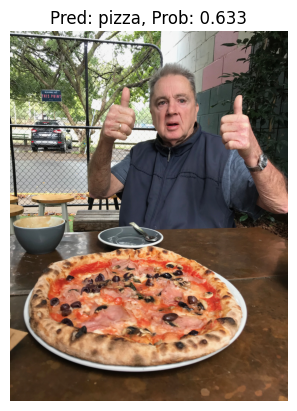

In [22]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model = model,
                    image_path = custom_image_path,
                    class_names = classes)